In [217]:
import ROOT as r
import math
import array
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
from math import pi
import pandas as pd
from scipy.optimize import curve_fit


#______________Add include directory_______________
current_dir = os.getcwd()
include_dir = os.path.join(current_dir, '../include')
sys.path.insert(0, include_dir)
#__________________________________________________
import ERROR
import CONFIG
import DBPARSE
from PXPY import *
from ASYMMETRY import *
from UTILITIES import *
from SIMFITS import DistributionFits
from ROOT import gStyle, TChain, TH1F, TCanvas, TLegend
import CORRECTIONS
import CALCULATE
import GETFF
from joblib import Parallel, delayed
import importlib
import ROOT
#importlib.reload(ASYMMETRY)

In [240]:
Pass="2"
config="4a"
useGrinch=False
base_dir = f"/media/research/TOSHIBA EXT/GEn/NumpyData/Pass{Pass}/GEN{config}/Timing"
generic=np.load(f"{base_dir}/timing2_0.npz")

In [241]:
c = 0.299792458
etof0 = (1.96+3.0)/c

In [242]:
coinmin=CONFIG.Function_JSON("coinmin",f"../config/Pass{Pass}/cuts{config}.cfg")
coinmax=CONFIG.Function_JSON("coinmax",f"../config/Pass{Pass}/cuts{config}.cfg")

In [243]:
import numpy as np
import os
from numpy.linalg import svd

tdiff_max=10


def accumulate_internal_alignment(M, b, event_counts, cblkatime, cblkid,nblk, n_blocks=288):
    n_events = cblkatime.shape[0]

    for ev in range(n_events):
        if ev % 10000 == 0:
            print(f"    Processing event {ev}/{n_events} {ev/n_events*100:.4f}%", end='\r', flush=True)

        
        times = cblkatime[ev][:int(nblk[ev])]
        ids = cblkid[ev][:int(nblk[ev])]
        
        for i in range(int(nblk[ev])):
            
            id_i = int(ids[i])
            t_i = times[i]
            
            if i==0:
                tmean0=t_i
            if abs(t_i-tmean0)>tdiff_max: continue 
            if not (0 <= id_i < n_blocks) or np.isnan(t_i):
                continue

            for j in range(i+1, int(nblk[ev])):
                id_j = int(ids[j])
                t_j = times[j]
                if not (0 <= id_j < n_blocks) or np.isnan(t_j):
                    continue

                dt = t_i - t_j
                if abs(dt)>tdiff_max: continue
                #if ev % 100000 == 0:
                #    print(f"nblk= {nblk[ev]}, length:{len(ids)}, dt:{dt}")
                event_counts[id_i] += 1
                event_counts[id_j] += 1

                b[id_i] += dt
                b[id_j] -= dt

                M[id_i, id_i] += 1
                M[id_j, id_j] += 1
                M[id_i, id_j] -= 1
                M[id_j, id_i] -= 1

def solve_internal_alignment(M, b, event_counts, refID=0, min_events=100):
    n_blocks = M.shape[0]
    for i in range(n_blocks):
        if event_counts[i] < min_events:
            b[i] = 0
            M[i, :] = 0
            M[:, i] = 0
            M[i, i] = 1

    U, S, Vt = svd(M)
    S_inv = np.array([1/s if s > 1e-10 else 0 for s in S])
    M_inv = Vt.T @ np.diag(S_inv) @ U.T
    delta = M_inv @ b

    corr = -delta[refID]
    delta += corr

    return delta

def chunkwise_internal_alignment(base_dir, prefix="timing2_", max_chunks=None, refID=0,BBCAL=False):
    if BBCAL: n_blocks=189
    else: n_blocks = 288
    M = np.zeros((n_blocks, n_blocks))
    b = np.zeros(n_blocks)
    event_counts = np.zeros(n_blocks)

    i = 0
    while True:
        if max_chunks and i >= max_chunks:
            break

        path = os.path.join(base_dir, f"{prefix}{i}.npz")
        if not os.path.exists(path):
            break

        print(f"Loading chunk {i}: {path}")
        data = np.load(path)
        if BBCAL:
            times = data["cblkatimeB"]
            energy = data["cblkeB"]
            blkid = data["cblkidB"]
            nblk = data["nblkB"]
        else:
            times = data["cblkatime"]
            energy = data["cblke"]
            blkid = data["cblkid"] - 1
            nblk = data["nblk"]
        if BBCAL:
            energycut = (energy[:, 0] < 5) & (energy[:, 0] > 0)
            blkcut = (nblk < 11) & (nblk>0)
            mask = energycut & blkcut
        else:
            timecut = (times[:, 0] < 250) & (times[:, 0] > 50)
            energycut = (energy[:, 0] < 5) & (energy[:, 0] > 0)
            blkcut = (nblk < 11) & (nblk>0)
            mask = timecut & energycut & blkcut
        
        accumulate_internal_alignment(M, b, event_counts, times[mask], blkid[mask],nblk[mask],
                                     n_blocks=n_blocks)

        i += 1

    return solve_internal_alignment(M, b, event_counts, refID)



In [244]:
#offsetsBBCAL= chunkwise_internal_alignment(base_dir,BBCAL=True)
#offsetsHCAL= chunkwise_internal_alignment(base_dir)

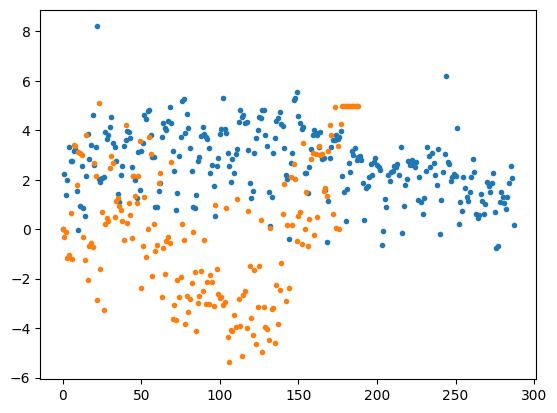

In [245]:

#np.save(f"DB/HCALinternalKin{config}.npy",offsetsHCAL)
#np.save(f"DB/BBCALinternalKin{config}.npy",offsetsBBCAL)
offsetsHCAL=np.load(f"DB/HCALinternalKin{config}.npy")
offsetsBBCAL=np.load(f"DB/BBCALinternalKin{config}.npy")
plt.plot(offsetsHCAL,'.')
plt.plot(offsetsBBCAL,'.')

In [260]:
import numpy as np
import os

def load_bbcal_hcal_corrected_deltas(base_dir, offsetsHCAL, offsetsBBCAL, prefix="timing2_", max_chunks=None):
    corrected_deltas = []
    raw_deltas = []

    i = 0
    while True:
        if max_chunks and i >= max_chunks:
            break

        path = os.path.join(base_dir, f"{prefix}{i}.npz")
        if not os.path.exists(path):
            break

        print(f"Processing chunk {i}", end='\r', flush=True)
        generic = np.load(path)

        # Extract variables
        cblkatime  = np.transpose(generic["cblkatime"])[0]
        cblkatimeB = np.transpose(generic["cblkatimeB"])[0]
        cblkid     = np.transpose(generic["cblkid"])[0] - 1  # HCAL offset
        cblkidB    = np.transpose(generic["cblkidB"])[0]
        
        

        # Initial mask to remove invalid IDs
        mask = (cblkidB >= 0) & (cblkidB < 189) & (cblkid >= 0) & (cblkid < 288)
        pathl=generic["pathl"][mask]
        etof=pathl/c-etof0
        cidB = cblkidB[mask].astype(int)
        cidH = cblkid[mask].astype(int)

        # Recheck to avoid accidental wrap-around
        valid = (cidB >= 0) & (cidB < 189) & (cidH >= 0) & (cidH < 288)
        cidB = cidB[valid]
        cidH = cidH[valid]

        BBOFF = offsetsBBCAL[cidB]
        HCALOFF = offsetsHCAL[cidH]

        # Other variables
        w2 = generic["W2"][mask][valid]
        dx = generic["dx"][mask][valid]
        dy = generic["dy"][mask][valid]

        ctimeB = cblkatimeB[mask][valid]
        ctimeH = cblkatime[mask][valid]

        BBCALCORR = ctimeB - BBOFF
        HCALCORR = ctimeH - HCALOFF

        cut = (w2 < 2) & (w2 > 0) & (np.abs(dx) < 0.5) & (np.abs(dy) < 0.5)

        corrected_deltas.append(HCALCORR[cut] - BBCALCORR[cut] - 120)
        raw_deltas.append(ctimeH[cut] - ctimeB[cut] - 129)
        #corrected_deltas.append(HCALCORR - BBCALCORR - 120)
        #raw_deltas.append(ctimeH - ctimeB - 129)

        i += 1

    print()
    return (
        np.concatenate(corrected_deltas),
        np.concatenate(raw_deltas)
    )


In [261]:
correctedCoin,rawCoin=load_bbcal_hcal_corrected_deltas(base_dir, offsetsHCAL, offsetsBBCAL)


Processing chunk 2


Text(0.5, 1.0, 'Internally Aligned HCAL BBCAL coin')

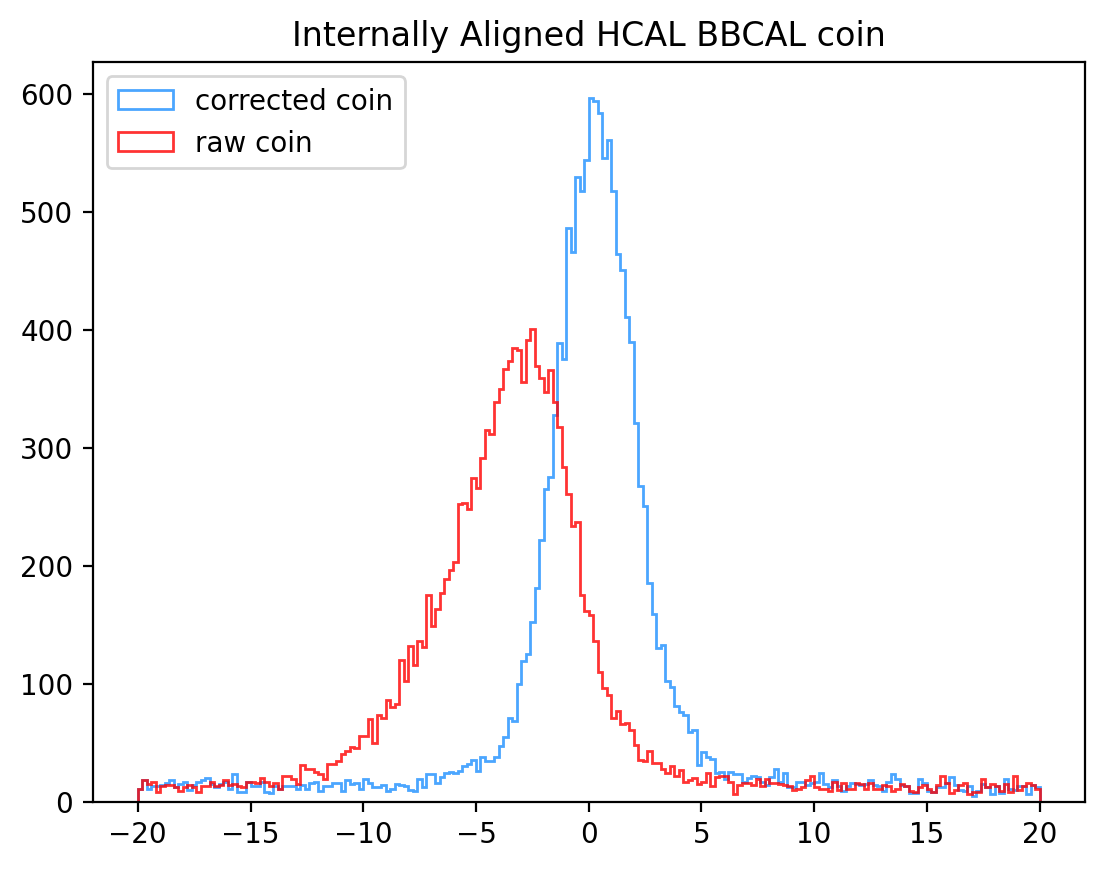

In [262]:
plt.figure(dpi=200)
d=plt.hist(correctedCoin-1,range=(-20,20),bins=200,alpha=.8,color='dodgerblue',histtype='step',
          label='corrected coin')
d=plt.hist(rawCoin,range=(-20,20),bins=200,alpha=.8,color='red',histtype='step',label='raw coin')
plt.legend(loc='upper left')
plt.title("Internally Aligned HCAL BBCAL coin")


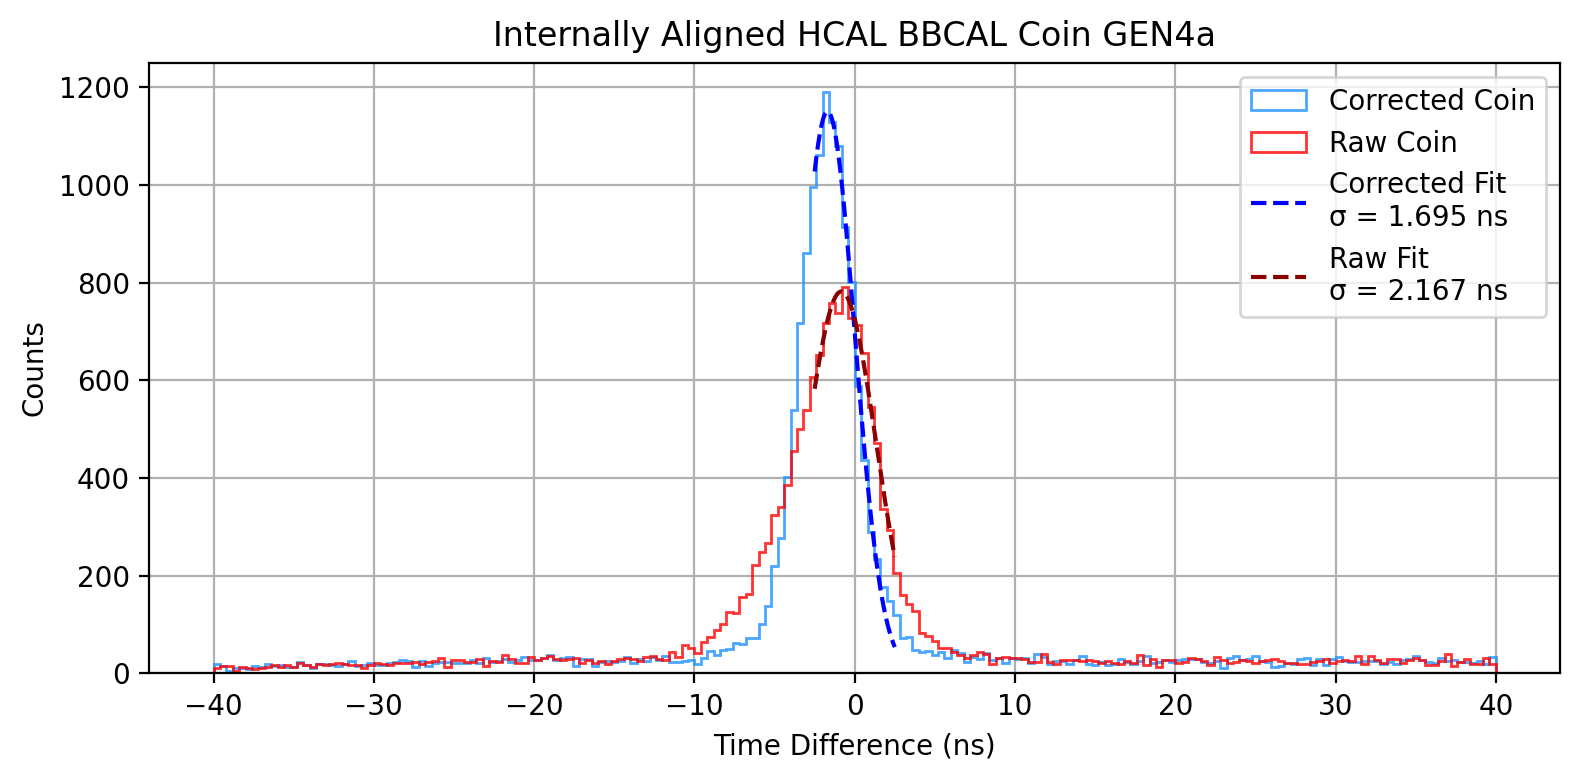

Corrected Fit: mu = -1.695 ns, sigma = 1.695 ns
Raw Fit:       mu = -0.839 ns, sigma = 2.167 ns


In [263]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Gaussian model
def gaussian(x, A, mu, sigma):
    return A * np.exp(-(x - mu)**2 / (2 * sigma**2))

coinmin = -2.5
coinmax = 2.5

# Plot histograms
plt.figure(dpi=200,figsize=(8,4))
d_corrected = plt.hist(correctedCoin -3, range=(-40, 40), bins=200, alpha=0.8, color='dodgerblue', histtype='step', label='Corrected Coin')
d_raw = plt.hist(rawCoin+2, range=(-40, 40), bins=200, alpha=0.8, color='red', histtype='step', label='Raw Coin')

# Bin centers
bin_edges = d_corrected[1]
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

# Fit corrected
y_corr = d_corrected[0]
mask_corr = (bin_centers > coinmin) & (bin_centers < coinmax)
x_corr = bin_centers[mask_corr]
y_corr_fit = y_corr[mask_corr]
p0_corr = [np.max(y_corr_fit), x_corr[np.argmax(y_corr_fit)], 2]
popt_corr, _ = curve_fit(gaussian, x_corr, y_corr_fit, p0=p0_corr)

# Fit raw
y_raw = d_raw[0]
mask_raw = (bin_centers > coinmin) & (bin_centers < coinmax)
x_raw = bin_centers[mask_raw]
y_raw_fit = y_raw[mask_raw]
p0_raw = [np.max(y_raw_fit), x_raw[np.argmax(y_raw_fit)], 2]
popt_raw, _ = curve_fit(gaussian, x_raw, y_raw_fit, p0=p0_raw)

# Plot fitted curves
x_fine = np.linspace(coinmin, coinmax, 1000)
plt.plot(x_fine, gaussian(x_fine, *popt_corr), linestyle='--', color='blue',
         label=f'Corrected Fit\nσ = {popt_corr[2]:.3f} ns')
plt.plot(x_fine, gaussian(x_fine, *popt_raw), linestyle='--', color='darkred',
         label=f'Raw Fit\nσ = {popt_raw[2]:.3f} ns')

# Labels and legend
plt.title(f"Internally Aligned HCAL BBCAL Coin GEN{config}")
plt.xlabel("Time Difference (ns)")
plt.ylabel("Counts")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Print numerical results
print(f"Corrected Fit: mu = {popt_corr[1]:.3f} ns, sigma = {popt_corr[2]:.3f} ns")
print(f"Raw Fit:       mu = {popt_raw[1]:.3f} ns, sigma = {popt_raw[2]:.3f} ns")


#  BELOW IS TRASH

# Make DB Compatible

In [264]:
import numpy as np

def parse_offset_block(lines, keyword):
    keyword_nospace = keyword.replace(" ", "").replace("=", "")
    offsets = []
    capture = False
    for line in lines:
        stripped = line.strip()
        stripped_nospace = stripped.replace(" ", "").replace("=", "")
        if not capture:
            if keyword_nospace == stripped_nospace:
                capture = True
                continue
        else:
            # New block starts, stop reading
            if "=" in stripped and stripped_nospace != keyword_nospace:
                break
            if stripped:
                try:
                    offsets.extend([float(x) for x in stripped.split()])
                except ValueError:
                    continue
    return np.array(offsets)



# Read old file
with open(f"DB/db_old_GEN{config}.txt", "r") as f:
    lines = f.readlines()
# Parse old values
oldHCal = parse_offset_block(lines, "sbs.hcal.adc.timeoffset =")
oldBBCal = parse_offset_block(lines, "bb.sh.adc.timeoffset =")

assert len(oldHCal) == len(offsetsHCAL), f"HCAL mismatch: {len(oldHCal)} vs {len(offsetsHCAL)}"
assert len(oldBBCal) == len(offsetsBBCAL), f"BBCAL mismatch: {len(oldBBCal)} vs {len(offsetsBBCAL)}"

# Add new and old offsets
sumHCAL = oldHCal - offsetsHCAL
sumBBCAL = oldBBCal - offsetsBBCAL

# Reshape
sumHCAL = sumHCAL.reshape(-1, 12)
sumBBCAL = sumBBCAL.reshape(-1, 7)

# Save to new DB file
with open(f"DB/db_GEN{config}.txt", "w") as f:
    f.write("sbs.hcal.adc.timeoffset =\n")
    for row in sumHCAL:
        f.write(" ".join(f"{x:.4f}" for x in row) + "\n")
    f.write("bb.sh.adc.timeoffset =\n")
    for row in sumBBCAL:
        f.write(" ".join(f"{x:.4f}" for x in row) + "\n")
